# Assignment 1 - Building a Vision Model with Keras

In this assignment, you will build a simple vision model using Keras. The goal is to classify images from the Fashion MNIST dataset, which contains images of clothing items.

You will:
1. Load and inspect the Fashion MNIST dataset.
2. Run a simple baseline model to establish a performance benchmark.
3. Build and evaluate a simple CNN model, choosing appropriate loss and metrics.
4. Design and run controlled experiments on one hyperparameter (e.g., number of filters, kernel size, etc.) and one regularization technique (e.g., dropout, L2 regularization).
5. Analyze the results and visualize the model's performance.

# 1. Loading and Inspecting the Dataset

Fashion MNIST is a dataset of grayscale images of clothing items, with 10 classes. Each image is 28x28 pixels, like the MNIST dataset of handwritten digits. Keras provides a convenient way to load this dataset. 

In this section, you should:

- [ ] Inspect the shapes of the training and test sets to confirm their size and structure.
- [ ] Convert the labels to one-hot encoded format if necessary. (There is a utility function in Keras for this.)
- [ ] Visualize a few images from the dataset to understand what the data looks like.

In [1]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Classes in the Fashion MNIST dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [2]:
# Inspect the shapes of the datasets
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)
print("y_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)

X_train.shape =  (60000, 28, 28)
X_test.shape =  (10000, 28, 28)
y_train.shape =  (60000,)
y_test.shape =  (10000,)


In [3]:
# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

print("y_train_cat.shape = ", y_train_cat.shape)
print("y_test_cat.shape = ", y_test_cat.shape)

y_train_cat.shape =  (60000, 10)
y_test_cat.shape =  (10000, 10)


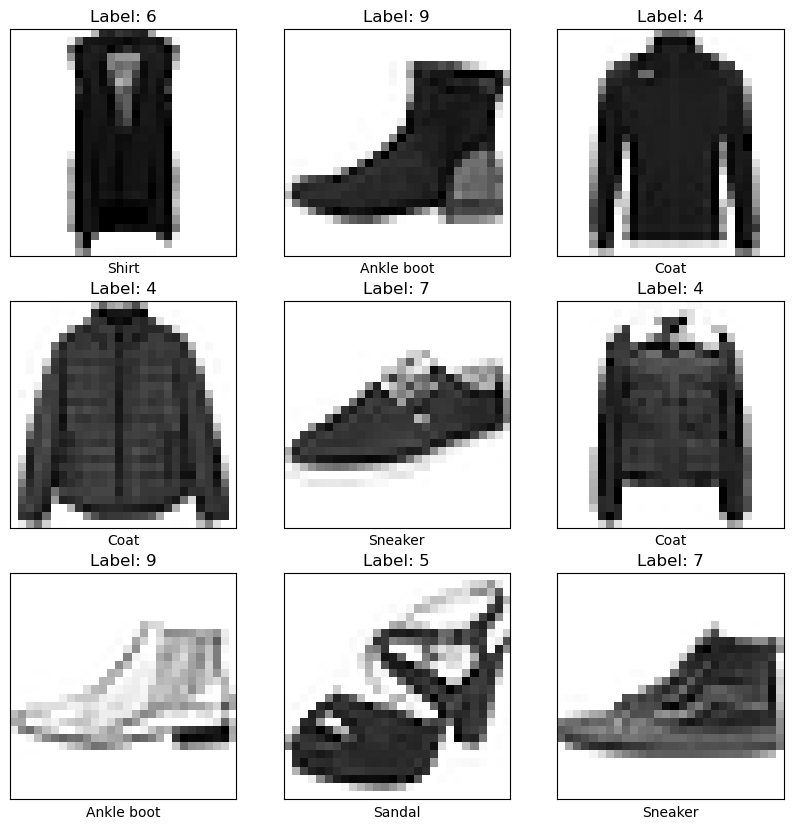

In [4]:
import matplotlib.pyplot as plt
# Verify the data looks as expected
import random
plt.figure(figsize=(10,10))
for i in range(9):
    image_no = random.randint(0, X_train.shape[0]-1)
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(X_train[image_no], cmap=plt.cm.gray_r, interpolation = 'nearest')
    plt.title(f"Label: {y_train[image_no]}")
    plt.xlabel(class_names[ y_train[image_no] ])
plt.show()


> class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Reflection: Does the data look as expected? How is the quality of the images? Are there any issues with the dataset that you notice?

**Your answer here**

Yes, the images appear as expected to me. The quality is low resolution, however I can distinguish the clothing / apparel object type pretty well if I lean back in my chair and view my computer screen from further away (my eyes are essentially implementing a smoothing or low-pass filter on the image). No, there are no issues with the dataset.

# 2. Baseline Model

In this section, you will create a linear regression model as a baseline. This model will not use any convolutional layers, but it will help you understand the performance of a simple model on this dataset.
You should:
- [ ] Create a simple linear regression model using Keras.
- [ ] Compile the model with an appropriate loss function and optimizer.
- [ ] Train the model on the training set and evaluate it on the test set.

A linear regression model can be created using the `Sequential` API in Keras. Using a single `Dense` layer with no activation function is equivalent to a simple linear regression model. Make sure that the number of units in the output layer matches the number of classes in the dataset.

Note that for this step, we will need to use `Flatten` to convert the 2D images into 1D vectors before passing them to the model. Put a `Flatten()` layer as the first layer in your model so that the 2D image data can be flattened into 1D vectors.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create a simple linear regression model
model = Sequential()

# model.add(Flatten()) # Note: from class recording: need to add this somewhere... (not shown exactly)
model.add(Flatten(input_shape = (28, 28)))

# You can use `model.add(<layer>)` to add layers to the model
model.add(Dense(10, activation = None)) # <-- activation = None ...implies a linear function)

model.summary()

# Compile the model using `model.compile()`
model.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer='sgd', # Optimizer -- Stochastic Gradient Descent
    metrics=['accuracy'] # Metrics to evaluate the model
)

# Train the model with `model.fit()`
model.fit(
    X_train, # Training data
    y_train_cat, # Training labels
    epochs=10, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

# Evaluate the model with `model.evaluate()`
model.evaluate(X_test, y_test_cat)

c:\Users\D_User\miniconda3\envs\dsi_participant\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1049 - loss: 8.7800 - val_accuracy: 0.1148 - val_loss: 9.3123
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1025 - loss: 8.3857 - val_accuracy: 0.0994 - val_loss: 9.8894
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1012 - loss: 10.0720 - val_accuracy: 0.0996 - val_loss: 9.9877
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0993 - loss: 10.1073 - val_accuracy: 0.0998 - val_loss: 10.4417
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1015 - loss: 10.4556 - val_accuracy: 0.0998 - val_loss: 10.7856
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1009 - loss: 10.8100 - val_accuracy: 0.0999 - val_loss: 11.0201
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1007 - loss: 11.0038 - val_accuracy: 0.0999 - val_loss: 11.0857
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1012 - loss: 

[11.189485549926758, 0.1005999967455864]

> Loss = 11.19, Accuracy = 0.1006 ~ 10 % (1/10 chance of being correct)

In [6]:
model.metrics_names

['loss', 'compile_metrics']

In [7]:
from collections import Counter
Counter(list(y_train_cat.argmax(axis=1)))

Counter({np.int64(9): 6000,
         np.int64(0): 6000,
         np.int64(3): 6000,
         np.int64(2): 6000,
         np.int64(7): 6000,
         np.int64(5): 6000,
         np.int64(1): 6000,
         np.int64(6): 6000,
         np.int64(4): 6000,
         np.int64(8): 6000})

Reflection: What is the performance of the baseline model? How does it compare to what you expected? Why do you think the performance is at this level?

**Your answer here**
> There is no "learning" taking place because the non-linear function is missing. The performance is essentially random chance (accuracy score of 10%... means a 1 in 10 chance of being correct, if the apparel objects are evenly distributed. As it indeed is... see cell immediately above.)

# 3. Building and Evaluating a Simple CNN Model

In this section, you will build a simple Convolutional Neural Network (CNN) model using Keras. A convolutional neural network is a type of deep learning model that is particularly effective for image classification tasks. Unlike the basic neural networks we have built in the labs, CNNs can accept images as input without needing to flatten them into vectors.

You should:
- [ ] Build a simple CNN model with at least one convolutional layer (to learn spatial hierarchies in images) and one fully connected layer (to make predictions).
- [ ] Compile the model with an appropriate loss function and metrics for a multi-class classification problem.
- [ ] Train the model on the training set and evaluate it on the test set.

Convolutional layers are designed to accept inputs with three dimensions: height, width and channels (e.g., RGB for color images). For grayscale images like those in Fashion MNIST, the input shape will be (28, 28, 1).

When you progress from the convolutional layers to the fully connected layers, you will need to flatten the output of the convolutional layers. This can be done using the `Flatten` layer in Keras, which doesn't require any parameters.

In [9]:
from keras.layers import Conv2D

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Create a simple CNN model
model_cnn = Sequential()

# one convolutional layer (to learn spatial hierarchies in images)
model_cnn.add(Conv2D(filters = 10, kernel_size = 8, activation = 'relu', input_shape = (28, 28, 1)))

# Flatten layer in Keras (which does not require any parameters)... see notes above
model_cnn.add(Flatten())

# one fully connected layer (to make predictions)
model_cnn.add(Dense(32, activation = 'relu'))

# output layer
model_cnn.add(Dense(10, activation = 'softmax'))

model_cnn.summary()

# Compile the model
model_cnn.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer = 'adam', #'sgd', # Optimizer -- Stochastic Gradient Descent
    metrics=['accuracy'] # Metrics to evaluate the model
)

# Train the model
# Train the model with `model.fit()`
model_cnn.fit(
    X_train, # Training data
    y_train_cat, # Training labels
    epochs=10, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

# Evaluate the model
# Evaluate the model with `model.evaluate()`
model_cnn.evaluate(X_test, y_test_cat)

c:\Users\D_User\miniconda3\envs\dsi_participant\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 21, 21, 10)     │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4410)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │       141,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,132 (555.20 KB)

 Trainable params: 142,132 (555.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7750 - loss: 0.6473 - val_accuracy: 0.8645 - val_loss: 0.3815
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8683 - loss: 0.3660 - val_accuracy: 0.8685 - val_loss: 0.3632
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.8858 - loss: 0.3176 - val_accuracy: 0.8792 - val_loss: 0.3374
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9001 - loss: 0.2793 - val_accuracy: 0.8729 - val_loss: 0.3488
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9080 - loss: 0.2544 - val_accuracy: 0.8901 - val_loss: 0.3030
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9159 - loss: 0.2334 - val_accuracy: 0.8914 - val_loss: 0.3135
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9211 - loss: 0.2149 - val_accuracy: 0.8946 - val_loss: 0.3112
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9277 - lo

[0.3483611047267914, 0.8816999793052673]

> Loss = 0.36, Accuracy = 0.8729 ~ 87 % (using optimizer = 'sgd')
> Loss = 0.35, Accuracy = 0.8817 ~ 88 % (using optimizer = 'adam')
>
> So, negligible difference using 'sgd' vs 'adam'

In [10]:
model_cnn.metrics_names

['loss', 'compile_metrics']

Reflection: Did the CNN model perform better than the baseline model? If so, by how much? What do you think contributed to this improvement?

**Your answer here**

> Yes, the CNN model performed approximately 9x (nine times) better than the baseline. Using the non-linear activation helps the model to learn patterns in the image data.

# 4. Designing and Running Controlled Experiments

In this section, you will design and run controlled experiments to improve the model's performance. You will focus on one hyperparameter and one regularization technique.
You should:
- [ ] Choose one hyperparameter to experiment with (e.g., number of filters, kernel size, number of layers, etc.) and one regularization technique (e.g., dropout, L2 regularization). For your hyperparameter, you should choose at least three different values to test (but there is no upper limit). For your regularization technique, simply test the presence or absence of the technique.
- [ ] Run experiments by modifying the model architecture or hyperparameters, and evaluate the performance of each model on the test set.
- [ ] Record the results of your experiments, including the test accuracy and any other relevant metrics.
- [ ] Visualize the results of your experiments using plots or tables to compare the performance of different models.

The best way to run your experiments is to create a `for` loop that iterates over a range of values for the hyperparameter you are testing. For example, if you are testing different numbers of filters, you can create a loop that runs the model with 32, 64, and 128 filters. Within the loop, you can compile and train the model, then evaluate it on the test set. After each iteration, you can store the results in a list or a dictionary for later analysis.

Note: It's critical that you re-initialize the model (by creating a new instance of the model) before each experiment. If you don't, the model will retain the weights from the previous experiment, which can lead to misleading results.

In [ ]:
# A. Test Hyperparameters

eval_results = [] # initialize array / list to store evaluation results

for no_filters in [32, 64, 128]:
    print(f"Testing with No. of filters = {no_filters}")

    # Create a simple CNN model
    model_cnn = Sequential()

    # one convolutional layer (to learn spatial hierarchies in images)
    model_cnn.add(Conv2D(filters = no_filters, kernel_size = 8, activation = 'relu', input_shape = (28, 28, 1)))

    # Flatten layer in Keras (which does not require any parameters)... see notes above
    model_cnn.add(Flatten())

    # one fully connected layer (to make predictions)
    model_cnn.add(Dense(32, activation = 'relu'))

    # output layer
    model_cnn.add(Dense(10, activation = 'softmax'))

    model_cnn.summary()

    # Compile the model
    model_cnn.compile(
        loss='categorical_crossentropy', # Loss function
        optimizer = 'adam', #'sgd', # Optimizer -- Stochastic Gradient Descent
        metrics=['accuracy'] # Metrics to evaluate the model
    )

    # Train the model
    # Train the model with `model.fit()`
    model_cnn.fit(
        X_train, # Training data
        y_train_cat, # Training labels
        epochs=10, # Number of epochs
        batch_size=32, # Number of samples per batch
        validation_split=0.2 # Use 20% of the data for validation
    )

    # Evaluate the model
    # Evaluate the model with `model.evaluate()`
    eval_results.append(model_cnn.evaluate(X_test, y_test_cat)) # <-- stores each result in the array / list


Testing with No. of filters = 32


c:\Users\D_User\miniconda3\envs\dsi_participant\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │       451,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,026 (1.73 MB)

 Trainable params: 454,026 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.7701 - loss: 0.6627 - val_accuracy: 0.8655 - val_loss: 0.3817
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8742 - loss: 0.3531 - val_accuracy: 0.8827 - val_loss: 0.3223
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.8948 - loss: 0.2910 - val_accuracy: 0.8883 - val_loss: 0.3125
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.9033 - loss: 0.2602 - val_accuracy: 0.8863 - val_loss: 0.3212
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.9148 - loss: 0.2361 - val_accuracy: 0.8982 - val_loss: 0.2924
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9233 - loss: 0.2088 - val_accuracy: 0.8953 - val_loss: 0.3026
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9294 - loss: 0.1911 - val_accuracy: 0.8954 - val_loss: 0.3021
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9361 -

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │       903,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,690 (3.46 MB)

 Trainable params: 907,690 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.7831 - loss: 0.6053 - val_accuracy: 0.8708 - val_loss: 0.3542
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - accuracy: 0.8787 - loss: 0.3321 - val_accuracy: 0.8796 - val_loss: 0.3382
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.8972 - loss: 0.2787 - val_accuracy: 0.8898 - val_loss: 0.3043
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.9092 - loss: 0.2462 - val_accuracy: 0.8921 - val_loss: 0.3040
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.9178 - loss: 0.2216 - val_accuracy: 0.8980 - val_loss: 0.2925
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - accuracy: 0.9291 - loss: 0.1922 - val_accuracy: 0.8968 - val_loss: 0.2994
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - accuracy: 0.9354 - loss: 0.1704 - val_accuracy: 0.8958 - val_loss: 0.3003
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.9430 -

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │     1,806,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,815,018 (6.92 MB)

 Trainable params: 1,815,018 (6.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 89s 58ms/step - accuracy: 0.7855 - loss: 0.6006 - val_accuracy: 0.8770 - val_loss: 0.3477
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 89s 59ms/step - accuracy: 0.8830 - loss: 0.3216 - val_accuracy: 0.8798 - val_loss: 0.3272
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 92s 61ms/step - accuracy: 0.8985 - loss: 0.2762 - val_accuracy: 0.8903 - val_loss: 0.3085
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 89s 59ms/step - accuracy: 0.9138 - loss: 0.2359 - val_accuracy: 0.8958 - val_loss: 0.2999
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 146s 62ms/step - accuracy: 0.9219 - loss: 0.2090 - val_accuracy: 0.8949 - val_loss: 0.3090
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 141s 61ms/step - accuracy: 0.9301 - loss: 0.1839 - val_accuracy: 0.8947 - val_loss: 0.3092
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 94s 63ms/step - accuracy: 0.9401 - loss: 0.1636 - val_accuracy: 0.9005 - val_loss: 0.3011
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 95s 63ms/step - accuracy: 0.9443

In [23]:
eval_results

[[0.35644617676734924, 0.8934999704360962],
 [0.350635290145874, 0.8939999938011169],
 [0.39219385385513306, 0.8889999985694885]]

> By observation, the second model (No. of filters = 64) i.e. the second tuple in the 'eval_results' array / list yielded the lowest loss & highest accuracy score
> Loss = 0.35, Accuracy = 0.894 ~ 89 %  
>
> So I suppose that I should further investigate the CNN model using 64 filters.

> Rough graph... for quick visual comparison only

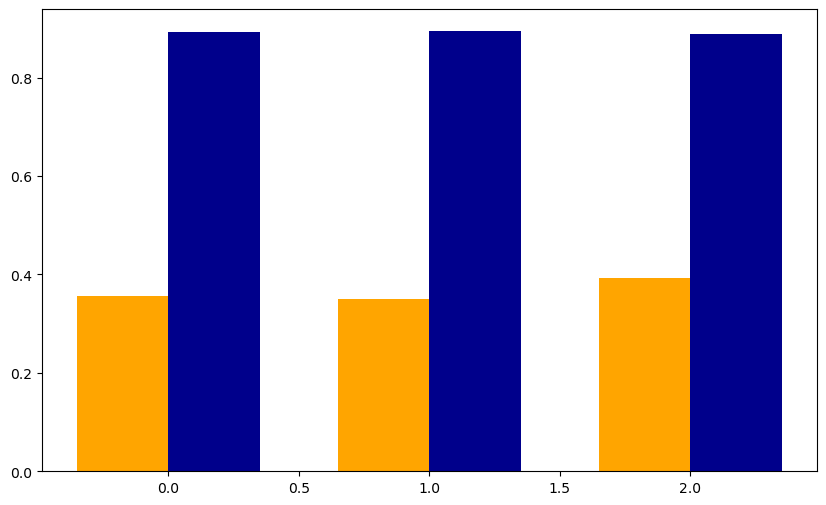

In [28]:
# Note: obtained code using Google Gemini 2.5 Flash
import matplotlib.pyplot as plt
import numpy as np

# separate out the data into 2 arrays / lists
losses = [item[0] for item in eval_results]
accuracies = [item[1] for item in eval_results]

# Labels for the three models
labels = ['32', '64', '128']
# Number of groups (the three data points)
x = np.arange(len(labels))
# Width of the bars
width = 0.35

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'Loss' bars
# The first set of bars is placed slightly to the left of the x tick mark
rects1 = ax.bar(x - width/2, losses, width, label='Loss', color='orange')

# Plot 'Accuracy' bars
# The second set of bars is placed slightly to the right of the x tick mark
rects2 = ax.bar(x + width/2, accuracies, width, label='Accuracy', color='darkblue')



In [30]:
# B. Test presence or absence of regularization

# Adding 50 % 'Dropout' regularization (p = 0.5) to the CNN model (No. filters = 64)
from keras.layers import Dropout

# Create a simple CNN model
model_cnn_do_50 = Sequential()

# one convolutional layer (to learn spatial hierarchies in images)
model_cnn_do_50.add(Conv2D(filters = 64, kernel_size = 8, activation = 'relu', input_shape = (28, 28, 1)))

# Flatten layer in Keras (which does not require any parameters)... see notes above
model_cnn_do_50.add(Flatten())

# one fully connected layer (to make predictions)
model_cnn_do_50.add(Dense(32, activation = 'relu'))

# ADD 50 % 'Dropout' regularization (p = 0.5)
model_cnn_do_50.add(Dropout(rate = 0.5, seed = 42))

# output layer
model_cnn_do_50.add(Dense(10, activation = 'softmax'))

model_cnn_do_50.summary()

# Compile the model
model_cnn_do_50.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer = 'adam', #'sgd', # Optimizer -- Stochastic Gradient Descent
    metrics=['accuracy'] # Metrics to evaluate the model
)

# Train the model
# Train the model with `model.fit()`
model_cnn_do_50.fit(
    X_train, # Training data
    y_train_cat, # Training labels
    epochs=10, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

# Evaluate the model
# Evaluate the model with `model.evaluate()`
model_cnn_do_50.evaluate(X_test, y_test_cat)


c:\Users\D_User\miniconda3\envs\dsi_participant\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │       903,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,690 (3.46 MB)

 Trainable params: 907,690 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.5997 - loss: 1.0938 - val_accuracy: 0.8482 - val_loss: 0.4192
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.7670 - loss: 0.6299 - val_accuracy: 0.8639 - val_loss: 0.3741
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.7911 - loss: 0.5540 - val_accuracy: 0.8736 - val_loss: 0.3567
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 34ms/step - accuracy: 0.8060 - loss: 0.5117 - val_accuracy: 0.8777 - val_loss: 0.3453
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.8222 - loss: 0.4770 - val_accuracy: 0.8842 - val_loss: 0.3301
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step - accuracy: 0.8305 - loss: 0.4578 - val_accuracy: 0.8859 - val_loss: 0.3269
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - accuracy: 0.8405 - loss: 0.4321 - val_accuracy: 0.8913 - val_loss: 0.3109
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.8444 -

[0.33288145065307617, 0.8853999972343445]

> Loss = 0.33, Accuracy = 0.8854 ~ 89 % model with Dropout rate = 50 % (p = 0.5) (No. of filters = 64)

> Loss = 0.35, Accuracy = 0.894 ~ 89 % model without Dropout (No. of filters = 64)

Reflection: Report on the performance of the models you tested. Did any of the changes you made improve the model's performance? If so, which ones? What do you think contributed to these improvements? Finally, what combination of hyperparameters and regularization techniques yielded the best performance?

**Your answer here**

> I am no expert, but based solely on the numbers, I would say that any perceived difference among the various CNN models is negligible.

> I will run my final CNN model with simple parameters and ignore regularization. (No. of filters = 8 and optimizer = 'sgd')

# 5. Training Final Model and Evaluation

In this section, you will train the final model using the best hyperparameters and regularization techniques you found in the previous section. You should:
- [ ] Compile the final model with the best hyperparameters and regularization techniques.
- [ ] Train the final model on the training set and evaluate it on the test set.
- [ ] Report the final model's performance on the test set, including accuracy and any other relevant metrics.

In [31]:
# Create a simple CNN model
model_cnn_final = Sequential()

# one convolutional layer (to learn spatial hierarchies in images)
model_cnn_final.add(Conv2D(filters = 8, kernel_size = 8, activation = 'relu', input_shape = (28, 28, 1)))

# Flatten layer in Keras (which does not require any parameters)... see notes above
model_cnn_final.add(Flatten())

# one fully connected layer (to make predictions)
model_cnn_final.add(Dense(32, activation = 'relu'))

# output layer
model_cnn_final.add(Dense(10, activation = 'softmax'))

model_cnn_final.summary()

# Compile the model
model_cnn_final.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer = 'sgd', # Optimizer -- Stochastic Gradient Descent
    metrics=['accuracy'] # Metrics to evaluate the model
)

# Train the model
# Train the model with `model.fit()`
model_cnn_final.fit(
    X_train, # Training data
    y_train_cat, # Training labels
    epochs=10, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

# Evaluate the model
# Evaluate the model with `model.evaluate()`
model_cnn_final.evaluate(X_test, y_test_cat)

c:\Users\D_User\miniconda3\envs\dsi_participant\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 21, 21, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3528)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │       112,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,778 (444.45 KB)

 Trainable params: 113,778 (444.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6253 - loss: 1.0752 - val_accuracy: 0.8016 - val_loss: 0.5488
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8121 - loss: 0.5262 - val_accuracy: 0.8321 - val_loss: 0.4788
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8358 - loss: 0.4637 - val_accuracy: 0.8486 - val_loss: 0.4319
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8487 - loss: 0.4228 - val_accuracy: 0.8489 - val_loss: 0.4205
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8581 - loss: 0.3987 - val_accuracy: 0.8580 - val_loss: 0.3942
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8656 - loss: 0.3774 - val_accuracy: 0.8638 - val_loss: 0.3837
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8707 - loss: 0.3607 - val_accuracy: 0.8705 - val_loss: 0.3661
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8752 - loss: 0

[0.35523736476898193, 0.8751000165939331]

> __Final CNN model performance__  
> Loss = 0.35, Accuracy = 0.8751 ~ 88 % (simpler model with No. of filters = 8 and optimizer = 'sgd')  
>
> in comparison with to evaulated / 'optimized' model (No. of filters = 64 and optimizer = 'adam')  
> Loss = 0.35, Accuracy = 0.894 ~ 89 %

__Summary comparison of main results__

| Final CNN model | 'Optimized' model |
|-----------------|-------------------|
| 0.35            | 0.35              | Loss
| 88 %            | 89 %              | Accuracy
| 8               | 64                | No. of filters
| 'sgd'           | 'adam'            | optimizer


Reflection: How does the final model's performance compare to the baseline and the CNN model? What do you think contributed to the final model's performance? If you had time, what other experiments would you run to further improve the model's performance?

**Your answer here**

> My final CNN model is fairly simple (8 filters & 'sgd' optimizer) compared to all the hyperparameter evaluations I ran, however, it's performance is comparable as the results above show.  

> The CNN model is a definite improvement over my baseline model. (Note: I might have defined my baseline model incorrectly, because it seemed no better than random chance. (It's accuracy was ~ 10 %))

> Now, IMPORTANTLY, I do not know if close to 90 % accuracy is acceptable for my application. I shall assume for my hypothetical application that any accuracy better than 7 or 8 times out of 10 is acceptable.

> If I had time,
>
>       __I don't have time!__
> Just kidding :-) In reality, I would set an acceptable threshold for metrics (e.g. accuracy) and then pick the simplest model (with the fewest parameters, layers, etc.) that met this criteria and use that model in the application.  

>Unfortunately, one can end up spending a lot of time on textbook assessments & evaluations on sample / test data to achieve minimal theoreticl improvements. (Personal anecdote: I have spent approx. 4 hours so far on this assignment)  

> **I feel that it may be more productive to try it out, evaulate and tweak (if necessary) on real-world data samples.**

> I actually was not kidding about my lack of time to devote to this subject. BUT... if I could __MAKE__ time, I would follow Andrej Karpathy's blog tutorial and /or channel on YouTube to investigate more.

> https://karpathy.ai/zero-to-hero.html  

> https://www.youtube.com/watch?v=VMj-3S1tku0  


> Completed by DBB on Tue 28-Oct-2025 @ 10h40

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 26/10/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb)
    * The Lab 1 notebook (labs/lab_1.ipynb)
    * The Lab 2 notebook (labs/lab_2.ipynb)
    * The Lab 3 notebook (labs/lab_3.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.